<a href="https://colab.research.google.com/github/shubham151/CovidVaccineAnalysis/blob/main/CovidVaccine_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c("tidyverse", "lubridate", "ggplot2", "rtweet", "maps", "mapdata", "scales", "tm", "wordcloud", "RColorBrewer", "syuzhet"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’, ‘textshape’, ‘zoo’, ‘dtt’




In [14]:
library(tidyverse)
library(lubridate)
library(syuzhet)
library(ggplot2)
library(dplyr)

In [6]:
tweets_df <- read_csv("/content/covidvaccine.csv")

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 382816 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): user_name, user_location, user_description, user_created, date, tex...
dbl (3): user_followers, user_friends, user_favourites
lgl (2): user_verified, is_retweet

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
tweets_df <- tweets_df %>%
  mutate(date = ymd_hms(date),
         user_created = ymd_hms(user_created),
         user_verified = as.logical(user_verified),
         is_retweet = as.logical(is_retweet))

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `date = ymd_hms(date)`.
Caused by warning:
!  7 failed to parse.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


Sentiment Analysis Over Time

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


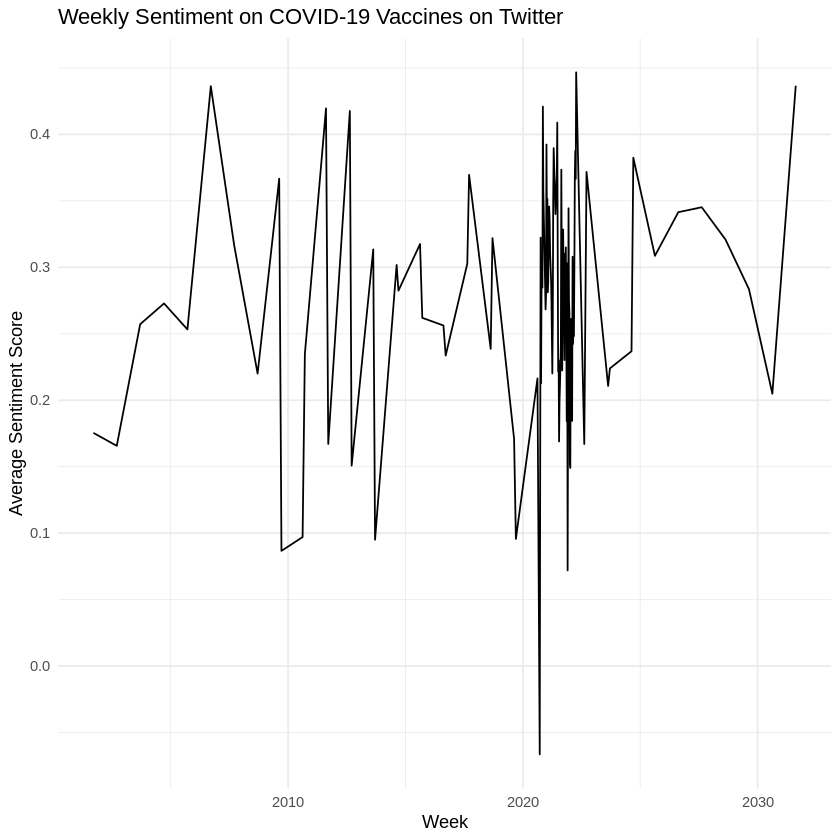

In [8]:
tweets_df <- tweets_df %>%
  mutate(sentiment = get_sentiment(text, method = "syuzhet"))

weekly_sentiment <- tweets_df %>%
  group_by(week = floor_date(date, "week")) %>%
  summarize(average_sentiment = mean(sentiment))

ggplot(weekly_sentiment, aes(x = week, y = average_sentiment)) +
  geom_line() +
  labs(title = "Weekly Sentiment on COVID-19 Vaccines on Twitter",
       x = "Week",
       y = "Average Sentiment Score") +
  theme_minimal()

In [9]:
library(tm)
library(wordcloud)

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


Loading required package: RColorBrewer



In [10]:
corpus <- Corpus(VectorSource(tweets_df$text))

Pre-Process

In [ ]:
corpus_clean <- corpus %>%
  tm_map(removePunctuation) %>%
  tm_map(removeNumbers) %>%
  tm_map(tolower) %>%
  tm_map(removeWords, stopwords("en")) %>%
  tm_map(stripWhitespace)

In [11]:
tdm <- TermDocumentMatrix(corpus)

In [ ]:
m <- as.matrix(tdm)
word_freqs <- sort(rowSums(m), decreasing = TRUE)

In [ ]:
wordcloud(names(word_freqs), freq = word_freqs, max.words = 100, random.order = FALSE, colors = brewer.pal(8, "Dark2"))

Engagement Analysis Based on User Followers and Friends

Warning message in scale_x_log10(labels = scales::comma):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(labels = scales::comma):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 57 rows containing missing values or values outside the scale range
(`geom_point()`).”


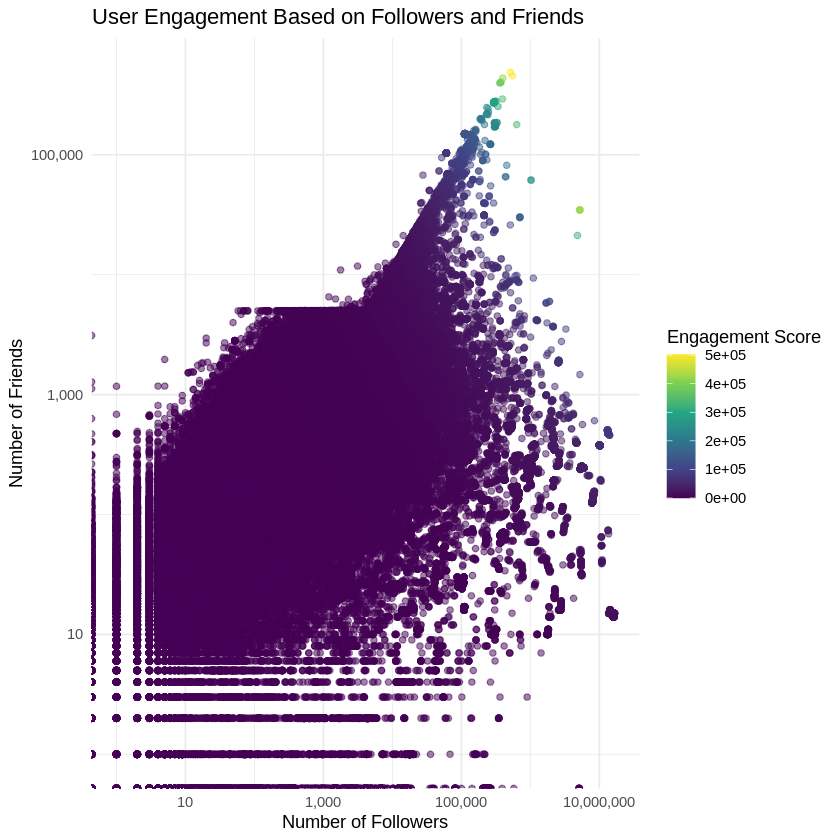

In [12]:
tweets_df$engagement_score <- with(tweets_df, sqrt(user_followers * user_friends))

ggplot(tweets_df, aes(x = user_followers, y = user_friends, color = engagement_score)) +
  geom_point(alpha = 0.5) +
  scale_color_viridis_c() +
  labs(title = "User Engagement Based on Followers and Friends",
       x = "Number of Followers",
       y = "Number of Friends",
       color = "Engagement Score") +
  theme_minimal() +
  scale_x_log10(labels = scales::comma) +
  scale_y_log10(labels = scales::comma)


Verified vs Non-Verified Users

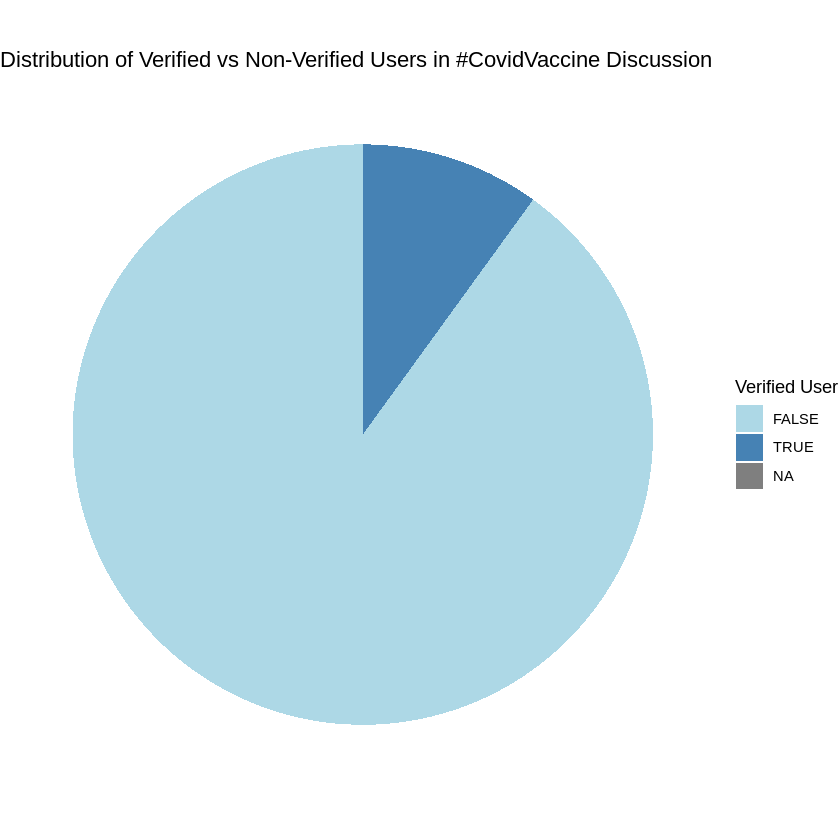

In [13]:
verified_counts <- tweets_df %>%
  group_by(user_verified) %>%
  summarise(count = n())

ggplot(verified_counts, aes(x = "", y = count, fill = factor(user_verified))) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  labs(title = "Distribution of Verified vs Non-Verified Users in #CovidVaccine Discussion",
       fill = "Verified User") +
  scale_fill_manual(values = c("TRUE" = "steelblue", "FALSE" = "lightblue"))
